### <b>Load Dataset</b>

* Set the image directory path and initialize PyTorch data loaders.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [15]:
transforms_train = transforms.Compose([
    transforms.Resize((480, 480)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_val = transforms.Compose([
    transforms.Resize((480, 480)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = '/home/gmz/Desktop/projects/amani/silinecek/archive'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'Train'), transforms_train)
val_datasets = datasets.ImageFolder(os.path.join(data_dir, 'Test'), transforms_val)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=16, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=16, shuffle=True, num_workers=4)

print('Train dataset size:', len(train_datasets))
print('Validation dataset size:', len(val_datasets))

class_names = train_datasets.classes
print('Class names:', class_names)

Train dataset size: 11135
Validation dataset size: 1279
Class names: ['Female', 'Male']


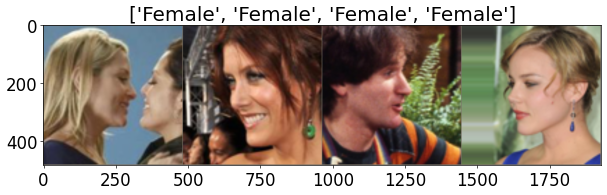

In [16]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

### <b>Define Model</b>

* We focus on a transfer learning method.

In [17]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2) # binary classification (num_of_class == 2)
model = model.to(device)
model_path = '/home/gmz/Desktop/projects/amani/Face-Gender-Classification-PyTorch/models/classification_model.pth'  
model.load_state_dict(torch.load(model_path, map_location=device))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.007, momentum=0.9)

/home/gmz/Desktop/projects/amani/Face-Gender-Classification-PyTorch/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gmz/Desktop/projects/amani/Face-Gender-Classification-PyTorch/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### <b>Training Phase</b>


In [19]:
import torch
import copy
import time
from sklearn.metrics import precision_score, recall_score, f1_score
import wandb

num_epochs = 60
start_time = time.time()

# Wandb projesini başlat
wandb.init(project="gender", name="27122023")

# En iyi modeli saklamak için değişkenler
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
try:
    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            running_precision = 0.0
            running_recall = 0.0
            running_f1 = 0.0

            dataloader = train_dataloader if phase == 'train' else val_dataloader
            dataset_size = len(train_datasets) if phase == 'train' else len(val_datasets)

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                precision = precision_score(labels.cpu().data, preds.cpu(), average='macro', zero_division=0)
                recall = recall_score(labels.cpu().data, preds.cpu(), average='macro', zero_division=0)
                f1 = f1_score(labels.cpu().data, preds.cpu(), average='macro', zero_division=0)
                running_precision += precision
                running_recall += recall
                running_f1 += f1

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            epoch_precision = running_precision / len(dataloader)
            epoch_recall = running_recall / len(dataloader)
            epoch_f1 = running_f1 / len(dataloader)

            print(f'[{phase} #{epoch}] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f} F1: {epoch_f1:.4f}')

            wandb.log({f"{phase}_loss": epoch_loss, f"{phase}_acc": epoch_acc, f"{phase}_precision": epoch_precision, f"{phase}_recall": epoch_recall, f"{phase}_f1": epoch_f1})

            # En iyi modeli kontrol et ve kaydet
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
except KeyboardInterrupt:
        print("Eğitim erken durduruldu. En iyi model kaydediliyor.")


finally:
    # En iyi modeli 'best_model.pth' olarak kaydet
    torch.save(best_model_wts, 'best_model.pth')
    print(f"En iyi model 'best_model.pth' olarak kaydedildi. En iyi doğruluk: {best_acc:.4f}")
    wandb.finish()


[train #0] Loss: 0.2782 Acc: 0.8933 Precision: 0.8989 Recall: 0.9037 F1: 0.8883
[val #0] Loss: 0.1766 Acc: 0.9406 Precision: 0.9422 Recall: 0.9369 F1: 0.9343
[train #1] Loss: 0.1715 Acc: 0.9385 Precision: 0.9375 Recall: 0.9434 F1: 0.9349
[val #1] Loss: 0.1586 Acc: 0.9523 Precision: 0.9542 Recall: 0.9462 F1: 0.9453
[train #2] Loss: 0.1475 Acc: 0.9482 Precision: 0.9448 Recall: 0.9530 F1: 0.9437
[val #2] Loss: 0.1494 Acc: 0.9609 Precision: 0.9555 Recall: 0.9626 F1: 0.9561
[train #3] Loss: 0.1214 Acc: 0.9569 Precision: 0.9560 Recall: 0.9598 F1: 0.9544
[val #3] Loss: 0.1503 Acc: 0.9531 Precision: 0.9534 Recall: 0.9462 F1: 0.9459
[train #4] Loss: 0.1031 Acc: 0.9633 Precision: 0.9616 Recall: 0.9656 F1: 0.9604
[val #4] Loss: 0.1520 Acc: 0.9562 Precision: 0.9586 Recall: 0.9521 F1: 0.9517
[train #5] Loss: 0.0901 Acc: 0.9677 Precision: 0.9665 Recall: 0.9697 F1: 0.9655
[val #5] Loss: 0.1578 Acc: 0.9562 Precision: 0.9564 Recall: 0.9547 F1: 0.9508
[train #6] Loss: 0.0756 Acc: 0.9742 Precision: 0.972

train_acc,▁▄▅▅▆▆▆▇▇▇▇▇▇█████████████████████
train_f1,▁▄▅▅▆▆▆▇▇▇▇▇▇█████████████████████
train_loss,█▅▅▄▃▃▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_precision,▁▄▄▅▅▆▆▆▆▇▇▇▇▇▇█▇▇████████████████
train_recall,▁▄▅▅▆▆▆▇▇▇▇▇▇█████████████████████
val_acc,▄▆▇▆▇▇▁▅▃▆▅▆▆▇▅▆▆▆▇▇▆▇▅█▇▆█▇█▇█▇█▇
val_f1,▄▆▇▆▇▇▁▄▃▆▅▆▆▇▆▆▆▆▇▇▅▇▅▇▇▇█▇█▇█▇█▇
val_loss,▃▂▁▁▁▂▆▃▇▅▃▃▄▄▄█▆▅▆▅▆▆▇▃▄▇▄█▅▆▅▆▇▇
val_precision,▃▆▆▆▇▆▁▃▄▅▄▆▅▅▅▅▆▅▆▆▄▇▄▇▇▆███▇████
val_recall,▅▆█▆▆▇▁▅▂▇▅▅▆▇▆▇▆▆▇▇▅▇▆▆▇▇█▇▇▆█▇█▇
train_acc,0.99686


: 

### <b>Final Validation Phase</b>

* Save the trained model file.

* Load from the trained model file.

In [27]:
model = models.resnet18(pretrained=True)
save_path="best_model.pth"
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2) # binary classification (num_of_class == 2)
model.load_state_dict(torch.load(save_path))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

* Evaluate the trained model.

[Prediction Result Examples]


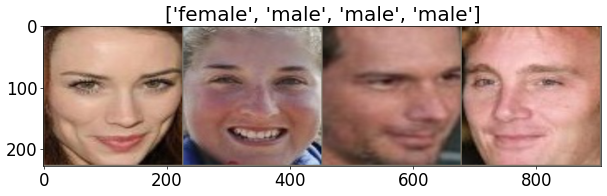

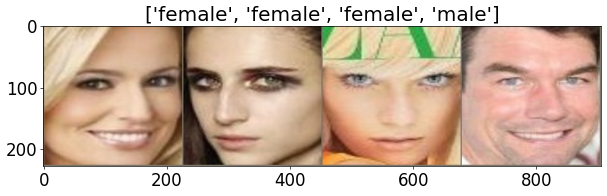

[Validation #2] Loss: 0.0773 Acc: 97.2186% Time: 23.5126s


In [28]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(val_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])

    epoch_loss = running_loss / len(val_datasets)
    epoch_acc = running_corrects / len(val_datasets) * 100.
    print('[Validation #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))